## Research Internship - MICS - CentraleSupelec - Felipe Moret & Ioane Muni Toke

## Simulating and Exploring Hawkes Processes using  tick library (XInitiative - École Polytechnique)

## Simulating a Poisson Process using tick library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tick.hawkes import SimuPoissonProcess
from tick.plot import plot_point_process

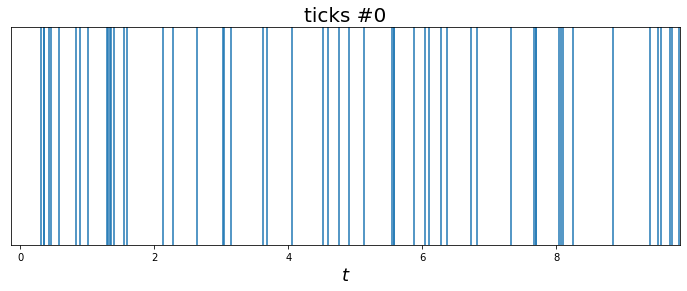

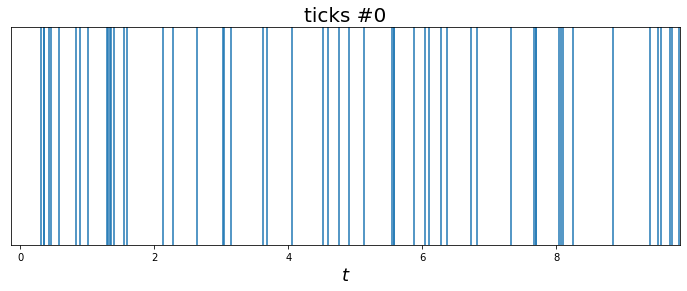

In [2]:
run_time = 10
intensity = 5

poi = SimuPoissonProcess(intensity, end_time=run_time, verbose=False)
poi.simulate()
plot_point_process(poi)

## Support Functions

In [2]:
def evaluate_mean_tuple(tuple_of_tuples):
    return [sum(y) / len(y) for y in zip(*tuple_of_tuples)]

In [3]:
def get_magnitude_order_for_delta(timestamps):
    differences_between_consecutive_timestamps = []
    number_of_jumps = len(timestamps)

    for i in range(0,number_of_jumps - 1):
        differences_between_consecutive_timestamps.append(timestamps[i+1] - timestamps[i])
        
    mean_difference_between_timestamps = np.mean(differences_between_consecutive_timestamps)
    std_difference_between_timestamps = np.std(differences_between_consecutive_timestamps)
    
    return mean_difference_between_timestamps, std_difference_between_timestamps

In [4]:
from tick.hawkes import SimuHawkes
from tick.plot import plot_hawkes_kernels
from tick.hawkes import SimuHawkesExpKernels, SimuHawkesMulti, HawkesExpKern
from tick.hawkes import HawkesKernelExp


def generate_exp_univariate_hawkes_process_least_squares(baseline, run_time, alpha, beta):
    
    hawkes = SimuHawkesExpKernels(decays = beta, adjacency = [[alpha]], baseline = [baseline], end_time = run_time, verbose = False, seed = None, max_jumps = 10000000)
  
    dt = 0.01
    hawkes.track_intensity(dt) 
    hawkes.simulate()

    timestamps = hawkes.timestamps
    intensity = hawkes.tracked_intensity
    intensity_times = hawkes.intensity_tracked_times


    learner_hawkes_exp = HawkesExpKern(beta, penalty = 'l2', C = 1000, max_iter = 10000, gofit = 'least-squares', step = 0.0001)
    learner_hawkes_exp.fit(hawkes.timestamps)

    ##plot_point_process(hawkes, n_points= 5000, t_min=0, max_jumps = 10000000)
    ##fig = plot_hawkes_kernels(learner_hawkes_exp, hawkes=hawkes, show=False)
    
    return (learner_hawkes_exp.coeffs), timestamps

In [8]:
from tick.hawkes import SimuHawkes
from tick.plot import plot_hawkes_kernels
from tick.hawkes import SimuHawkesExpKernels, SimuHawkesMulti, HawkesExpKern
from tick.hawkes import HawkesKernelExp


def generate_exp_univariate_hawkes_process_likelihood(baseline, run_time, alpha, beta):
    
    hawkes = SimuHawkesExpKernels(decays = beta, adjacency = [[alpha]], baseline = [baseline], end_time = run_time, verbose = False, seed = None, max_jumps = 10000000)
  
    dt = 0.01
    hawkes.track_intensity(dt)
    hawkes.simulate()

    timestamps = hawkes.timestamps
    intensity = hawkes.tracked_intensity
    intensity_times = hawkes.intensity_tracked_times


    learner_hawkes_exp = HawkesExpKern(beta, penalty='l2', C = 1000, max_iter = 1000, gofit = 'likelihood', step = 0.1)
    learner_hawkes_exp.fit(hawkes.timestamps)

    ##plot_point_process(hawkes, n_points= 5000, t_min=0, max_jumps = 10000000)
    ##fig = plot_hawkes_kernels(learner_hawkes_exp, hawkes=hawkes, show=False)
    
    return (learner_hawkes_exp.coeffs), timestamps

In [6]:
def nearest_delta_multiple(timestamp, delta):
    cumulative_sum = 0
    while(cumulative_sum <= timestamp):
        cumulative_sum += delta
    cumulative_sum -= delta
    return cumulative_sum

## What happens with $\hat{\alpha}\ and \ \hat{\lambda_{0}}$ if we permit time variations only to a fixed amount $\delta$ ?  (VERSION 1 - LEAST SQUARES)

**PS1: Simulations are done using a least-squares minimization for learning the Hawkes kernel.**

**PS2: We take care for avoiding repetitions of timestamps.**

In [37]:
def experiment_truncating_timestamps_least_squares(baseline, run_time, alpha, beta, number_of_simulations, number_of_truncate_deltas, min_delta, max_delta):
    
    parameters_truncate_0 = [None]*number_of_simulations

    baselines_for_different_truncate_deltas = np.zeros(number_of_truncate_deltas)
    alpha_for_different_truncate_deltas = np.zeros(number_of_truncate_deltas)
    endogeneity_for_different_truncate_deltas = np.zeros(number_of_truncate_deltas)
    
    parameters_results_truncate_deltas = [None]*number_of_simulations*number_of_truncate_deltas
    parameters_delta_0 = [None]*number_of_simulations
    
    truncate_deltas_vector = np.linspace(min_delta, max_delta, number_of_truncate_deltas)
    
    i = 0
    for simulations in range(0, number_of_simulations):
        parameters_truncate_0[simulations], timestamps = generate_exp_univariate_hawkes_process_least_squares(baseline, run_time, alpha, beta)
        #print("Simulation {}:\n".format(simulations))
        #print(timestamps[0])
        for truncate_delta in range(0, number_of_truncate_deltas):
            j = 0
            learner_hawkes_exp = HawkesExpKern(beta, penalty ='l2', C = 1000, p = 100, gofit = 'least-squares', step = 0.0001)
            number_of_jumps = len(timestamps[0])
            new_timestamps = np.zeros(number_of_jumps)
            for timestamp in timestamps[0]:
                new_time_stamp = nearest_delta_multiple(timestamp, truncate_deltas_vector[truncate_delta])
                new_timestamps[j] = new_time_stamp
                j += 1 
            new_timestamps = np.array(list(dict.fromkeys(new_timestamps)))
            #print("New timestamp:\n")
            #print(new_timestamps)
            learner_hawkes_exp.fit([new_timestamps])
            parameters_results_truncate_deltas[i] = (learner_hawkes_exp.coeffs)
            i += 1

    mean_results_deltas = [None]*number_of_truncate_deltas
    
    i = 0
    for truncate_delta in range(0, number_of_truncate_deltas):
            mean_results_deltas[truncate_delta] = evaluate_mean_tuple(parameters_results_truncate_deltas[i:i+2])
            i += 2
            
    #print(mean_results_deltas)
        
    mean_parameters_delta_0 = evaluate_mean_tuple(parameters_truncate_0 )
    
    baselines_for_different_truncate_deltas = []
    for truncate_delta in range(0, number_of_truncate_deltas):
        if(mean_results_deltas[truncate_delta] != []):
            baselines_for_different_truncate_deltas.append(mean_results_deltas[truncate_delta][0])
        
    alphas_for_different_truncate_deltas = []
    for truncate_delta in range(0, number_of_truncate_deltas):
        if(mean_results_deltas[truncate_delta] != []):
            alphas_for_different_truncate_deltas.append(mean_results_deltas[truncate_delta][1])
        
    endogeneity_for_different_truncate_deltas = []
    for truncate_delta in range(0, number_of_truncate_deltas):
        if(mean_results_deltas[truncate_delta] != []):
            endogeneity_for_different_truncate_deltas.append(mean_results_deltas[truncate_delta][1]/beta)
            

    plt.plot(truncate_deltas_vector, alphas_for_different_truncate_deltas, color = "r", marker = "x", markersize = 12, label = r"$\delta \neq 0$")
    plt.plot(0,mean_parameters_delta_0[1], color = "b", marker = "x", label = r"$\delta = 0$", markersize = 12) 
    plt.ylabel(r"$\hat{\alpha}$", fontsize = 18)
    plt.xlabel(r"$\delta$", fontsize = 18)
    plt.legend()
    plt.title(r"$\hat{{\alpha}}$ values for different $\delta$. True $\alpha = {}$".format(alpha))
    plt.show()
  
  
    plt.plot(truncate_deltas_vector, baselines_for_different_truncate_deltas, color = "r", marker = "x", markersize = 12, label = r"$\delta \neq 0$")
    plt.plot(0,mean_parameters_delta_0[0], color = "b", marker = "x", markersize = 12, label = r"$\delta = 0$")
    plt.ylabel(r"$\hat{{\lambda_{{0}}}}$", fontsize = 18)
    plt.xlabel(r"$\delta$", fontsize = 18)
    plt.legend()
    plt.title(r"$\hat{{\lambda_{{0}}}}$ values for different $\delta$. True $\lambda_{{0}} = {}$".format(baseline))
    plt.show()

    
    plt.plot(truncate_deltas_vector, endogeneity_for_different_truncate_deltas, color = "r", marker = "x", markersize = 12, label = r"$\delta \neq 0$")
    plt.plot(0,mean_parameters_delta_0[1]/beta, color = "b", marker = "x", label = r"$\delta = 0$", markersize = 12) 
    plt.ylabel(r"$\hat{{\alpha}/\hat{\beta}}$", fontsize = 18)
    plt.xlabel(r"$\delta$", fontsize = 18)
    plt.legend()
    plt.title(r"Endogeneity values for different $\delta$. True $\alpha/\beta = {}$".format(alpha/beta))
    plt.show()


    return  parameters_truncate_0, parameters_results_truncate_deltas, mean_parameters_delta_0, mean_results_deltas

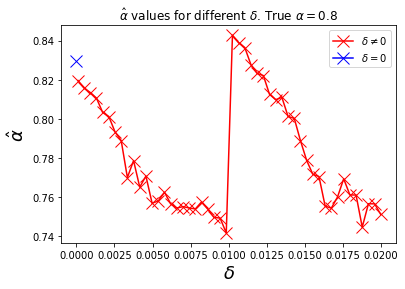

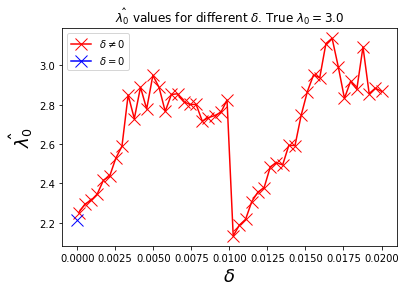

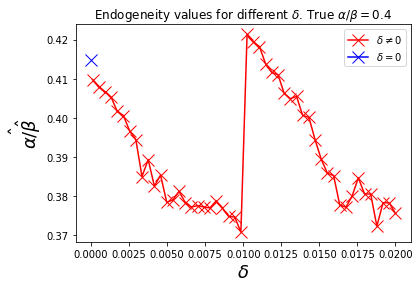

In [38]:
parameters_truncate_0_least_squares, parameters_results_truncate_deltas_least_squares, mean_parameters_truncate_delta_0_least_squares, mean_results_truncate_deltas_least_squares = experiment_truncating_timestamps_least_squares(3.0, 100, 0.8, 2, 50, 50, 0.0001, 0.02)

## What happens with $\hat{\alpha}\ and \ \hat{\lambda_{0}}$ if we permit time variations only to a fixed amount $\delta$ ?  (VERSION 1 - MAXIMIZATION OF LIKELIHOOD)

In [9]:
def experiment_truncating_timestamps_likelihood(baseline, run_time, alpha, beta, number_of_simulations, number_of_truncate_deltas, min_delta, max_delta):
    
    parameters_truncate_0 = [None]*number_of_simulations

    baselines_for_different_truncate_deltas = np.zeros(number_of_truncate_deltas)
    alpha_for_different_truncate_deltas = np.zeros(number_of_truncate_deltas)
    endogeneity_for_different_truncate_deltas = np.zeros(number_of_truncate_deltas)
    
    parameters_results_truncate_deltas = [None]*number_of_simulations*number_of_truncate_deltas
    parameters_delta_0 = [None]*number_of_simulations
    
    truncate_deltas_vector = np.linspace(min_delta, max_delta, number_of_truncate_deltas)
    
    i = 0
    for simulations in range(0, number_of_simulations):
        parameters_truncate_0[simulations], timestamps = generate_exp_univariate_hawkes_process_likelihood(baseline, run_time, alpha, beta)
        #print("Simulation {}:\n".format(simulations))
        #print(timestamps[0])
        for truncate_delta in range(0, number_of_truncate_deltas):
            j = 0
            learner_hawkes_exp = HawkesExpKern(beta, penalty ='l2', C = 1000, max_iter = 1000, gofit = 'likelihood', step = 0.1)
            number_of_jumps = len(timestamps[0])
            new_timestamps = np.zeros(number_of_jumps)
            for timestamp in timestamps[0]:
                new_time_stamp = nearest_delta_multiple(timestamp, truncate_deltas_vector[truncate_delta])
                new_timestamps[j] = new_time_stamp
                j += 1 
            new_timestamps = np.array(list(dict.fromkeys(new_timestamps)))
            #print("New timestamp:\n")
            #print(new_timestamps)
            learner_hawkes_exp.fit([new_timestamps])
            parameters_results_truncate_deltas[i] = (learner_hawkes_exp.coeffs)
            i += 1

    mean_results_deltas = [None]*number_of_truncate_deltas
    
    i = 0
    for truncate_delta in range(0, number_of_truncate_deltas):
            mean_results_deltas[truncate_delta] = evaluate_mean_tuple(parameters_results_truncate_deltas[i:i+2])
            i += 2
            
    #print(mean_results_deltas)
        
    mean_parameters_delta_0 = evaluate_mean_tuple(parameters_truncate_0 )
    
    baselines_for_different_truncate_deltas = []
    for truncate_delta in range(0, number_of_truncate_deltas):
        if(mean_results_deltas[truncate_delta] != []):
            baselines_for_different_truncate_deltas.append(mean_results_deltas[truncate_delta][0])
        
    alphas_for_different_truncate_deltas = []
    for truncate_delta in range(0, number_of_truncate_deltas):
        if(mean_results_deltas[truncate_delta] != []):
            alphas_for_different_truncate_deltas.append(mean_results_deltas[truncate_delta][1])
        
    endogeneity_for_different_truncate_deltas = []
    for truncate_delta in range(0, number_of_truncate_deltas):
        if(mean_results_deltas[truncate_delta] != []):
            endogeneity_for_different_truncate_deltas.append(mean_results_deltas[truncate_delta][1]/beta)
            

    plt.plot(truncate_deltas_vector, alphas_for_different_truncate_deltas, color = "r", marker = "x", markersize = 12, label = r"$\delta \neq 0$")
    plt.plot(0,mean_parameters_delta_0[1], color = "b", marker = "x", label = r"$\delta = 0$", markersize = 12) 
    plt.ylabel(r"$\hat{\alpha}$", fontsize = 18)
    plt.xlabel(r"$\delta$", fontsize = 18)
    plt.legend()
    plt.title(r"$\hat{{\alpha}}$ values for different $\delta$. True $\alpha = {}$".format(alpha))
    plt.show()
  
  
    plt.plot(truncate_deltas_vector, baselines_for_different_truncate_deltas, color = "r", marker = "x", markersize = 12, label = r"$\delta \neq 0$")
    plt.plot(0,mean_parameters_delta_0[0], color = "b", marker = "x", markersize = 12, label = r"$\delta = 0$")
    plt.ylabel(r"$\hat{{\lambda_{{0}}}}$", fontsize = 18)
    plt.xlabel(r"$\delta$", fontsize = 18)
    plt.legend()
    plt.title(r"$\hat{{\lambda_{{0}}}}$ values for different $\delta$. True $\lambda_{{0}} = {}$".format(baseline))
    plt.show()

    
    plt.plot(truncate_deltas_vector, endogeneity_for_different_truncate_deltas, color = "r", marker = "x", markersize = 12, label = r"$\delta \neq 0$")
    plt.plot(0,mean_parameters_delta_0[1]/beta, color = "b", marker = "x", label = r"$\delta = 0$", markersize = 12) 
    plt.ylabel(r"$\hat{{\alpha}/\hat{\beta}}$", fontsize = 18)
    plt.xlabel(r"$\delta$", fontsize = 18)
    plt.legend()
    plt.title(r"Endogeneity values for different $\delta$. True $\alpha/\beta = {}$".format(alpha/beta))
    plt.show()


    return  parameters_truncate_0, parameters_results_truncate_deltas, mean_parameters_delta_0, mean_results_deltas

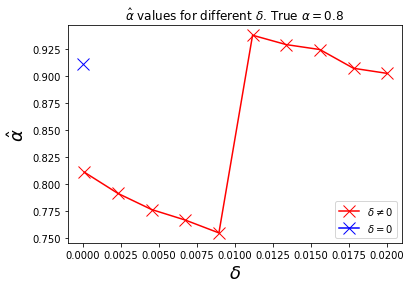

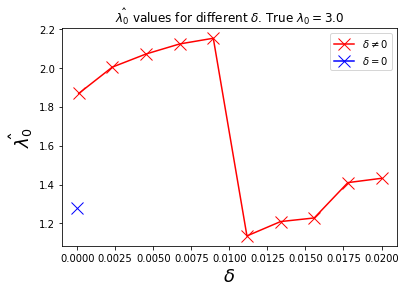

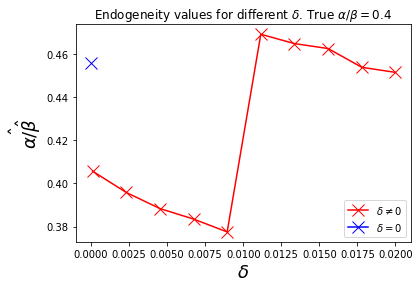

In [10]:
parameters_truncate_0_likelihood, parameters_results_truncate_deltas_likelihood, mean_parameters_truncate_delta_0_likelihood, mean_results_truncate_deltas_likelihood = experiment_truncating_timestamps_likelihood(3.0, 100, 0.8, 2, 10, 10, 0.0001, 0.02)

## What happens with $\hat{\alpha}\ and \ \hat{\lambda_{0}}$ when we add a certain value $\delta$ for the timestamps of Hawkes realizations ? (Using a likelihood maximization learner)

**PS1: Simulations are done using a likelihood maximization for learning the Hawkes kernel.**

**PS2: We take care for avoiding repetitions of timestamps.**

In [178]:
def experiment_varying_timestamps_likelihood(baseline, run_time, alpha, beta, number_of_deltas, number_of_simulations):
    
    parameters_delta_0 = [None]*number_of_simulations
    mean_consecutive_timestamps_difference = [None]*number_of_simulations
    std_consecutive_timestamps_difference = [None]*number_of_simulations
    min_delta = [None]*number_of_simulations
    max_delta = [None]*number_of_simulations
    
    for simulations in range(0, number_of_simulations):
        parameters_delta_0[simulations], timestamps = generate_exp_univariate_hawkes_process_likelihood(baseline, run_time, alpha, beta)
        mean_consecutive_timestamps_difference[simulations], std_consecutive_timestamps_difference[simulations] = get_magnitude_order_for_delta(timestamps[0])

    min_delta = np.mean(mean_consecutive_timestamps_difference) - 4*np.mean(std_consecutive_timestamps_difference)
    max_delta = np.mean(mean_consecutive_timestamps_difference) + 4*np.mean(std_consecutive_timestamps_difference)
    delta_vector = np.linspace(min_delta, max_delta, number_of_deltas)
    
    baselines_for_different_deltas = np.zeros(number_of_deltas)
    alpha_for_different_deltas = np.zeros(number_of_deltas)
    endogeneity_for_different_deltas = np.zeros(number_of_deltas)
    
    parameters_results_deltas = [None]*number_of_simulations*number_of_deltas
    parameters_delta_0 = [None]*number_of_simulations
    
    i = 0                   
    for simulations in range(0, number_of_simulations):
        parameters_delta_0[simulations], timestamps = generate_exp_univariate_hawkes_process_likelihood(baseline, run_time, alpha, beta)
        for delta in range(0, number_of_deltas):
            learner_hawkes_exp = HawkesExpKern(beta, penalty = 'l2', C = 1000, max_iter = 10000, gofit = 'likelihood', step = 0.1)
            learner_hawkes_exp.fit([timestamps[0] + np.ones(len(timestamps[0]))*delta_vector[delta]])
            parameters_results_deltas[i] = (learner_hawkes_exp.coeffs)
            i += 1

    mean_results_deltas = [None]*number_of_deltas
    
    i = 0
    for delta in range(0, number_of_deltas):
            mean_results_deltas[delta] = evaluate_mean_tuple(parameters_results_deltas[i:i+2])
            i += 2
        
    mean_parameters_delta_0 = evaluate_mean_tuple(parameters_delta_0 )
    
    baselines_for_different_deltas = []
    for delta in range(0, number_of_deltas):
        baselines_for_different_deltas.append(mean_results_deltas[delta][0])
        
    alphas_for_different_deltas = []
    for delta in range(0, number_of_deltas):
        alphas_for_different_deltas.append(mean_results_deltas[delta][1])
        
    endogeneity_for_different_deltas = []
    for delta in range(0, number_of_deltas):
        endogeneity_for_different_deltas.append(mean_results_deltas[delta][1]/beta)
        
    plt.plot(delta_vector, alphas_for_different_deltas, color = "r", marker = "x", markersize = 12, label = r"$\delta \neq 0$")
    plt.plot(0,mean_parameters_delta_0[1], color = "b", marker = "x", markersize = 12, label = r"$\delta = 0$") 
    plt.ylabel(r"$\hat{\alpha}$", fontsize = 18)
    plt.xlabel(r"$\delta$", fontsize = 18)
    plt.legend()
    plt.title(r"$\hat{{\alpha}}$ values for different $\delta$. True $\alpha = {}$".format(alpha))
    plt.show()

    
    plt.plot(delta_vector, baselines_for_different_deltas, color = "r", marker = "x", markersize = 12, label = r"$\delta \neq 0$")
    plt.plot(0,mean_parameters_delta_0[0], color = "b", marker = "x", markersize = 12, label = r"$\delta = 0$") 
    plt.ylabel(r"$\hat{{\lambda_{{0}}}}$", fontsize = 18)
    plt.xlabel(r"$\delta$", fontsize = 18)
    plt.legend()
    plt.title(r"$\hat{{\lambda_{{0}}}}$ values for different $\delta$. True $\lambda_{{0}} = {}$".format(baseline))
    plt.show()
    
    plt.plot(delta_vector, endogeneity_for_different_deltas, color = "r", marker = "x", markersize = 12, label = r"$\delta \neq 0$")
    plt.plot(0,mean_parameters_delta_0[1]/beta, color = "b", marker = "x", markersize = 12, label = r"$\delta = 0$") 
    plt.ylabel(r"$\hat{{\alpha}/\hat{\beta}}$", fontsize = 18)
    plt.xlabel(r"$\delta$", fontsize = 18)
    plt.legend()
    plt.title(r"Endogeneity values for different $\delta$. True $\alpha/\beta = {}$".format(alpha/beta))
    plt.show()

  
    return parameters_delta_0, parameters_results_deltas, mean_parameters_delta_0, mean_results_deltas
    

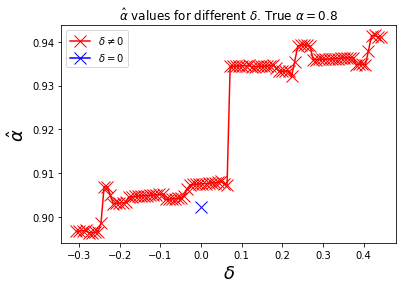

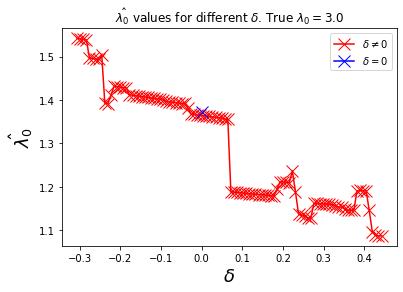

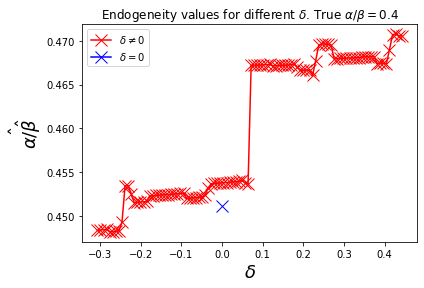

In [179]:
parameters_delta_0_varying_timestamps_likelihood, parameters_results_varying_timestamps_likelihood, mean_parameters_0_varying_timestamps_likelihood, mean_parameters_delta_varying_timestamps_likelihood = experiment_varying_timestamps_likelihood(3.0, 100, 0.8, 2.0, 100, 500)


## What happens with $\hat{\alpha}\ and \ \hat{\lambda_{0}}$ when we add a certain value $\delta$ for the timestamps of Hawkes realizations ? (Using a least-squares minimization learner)

In [53]:
def experiment_varying_timestamps_least_squares(baseline, run_time, alpha, beta, number_of_deltas, number_of_simulations):
    
    parameters_delta_0 = [None]*number_of_simulations
    mean_consecutive_timestamps_difference = [None]*number_of_simulations
    std_consecutive_timestamps_difference = [None]*number_of_simulations
    min_delta = [None]*number_of_simulations
    max_delta = [None]*number_of_simulations
    
    for simulations in range(0, number_of_simulations):
        parameters_delta_0[simulations], timestamps = generate_exp_univariate_hawkes_process_least_squares(baseline, run_time, alpha, beta)
        mean_consecutive_timestamps_difference[simulations], std_consecutive_timestamps_difference[simulations] = get_magnitude_order_for_delta(timestamps[0])

    min_delta = np.mean(mean_consecutive_timestamps_difference) - 4*np.mean(std_consecutive_timestamps_difference)
    max_delta = np.mean(mean_consecutive_timestamps_difference) + 4*np.mean(std_consecutive_timestamps_difference)
    delta_vector = np.linspace(min_delta, max_delta, number_of_deltas)
    
    baselines_for_different_deltas = np.zeros(number_of_deltas)
    alpha_for_different_deltas = np.zeros(number_of_deltas)
    endogeneity_for_different_deltas = np.zeros(number_of_deltas)
    
    parameters_results_deltas = [None]*number_of_simulations*number_of_deltas
    parameters_delta_0 = [None]*number_of_simulations
    
    i = 0                   
    for simulations in range(0, number_of_simulations):
        parameters_delta_0[simulations], timestamps = generate_exp_univariate_hawkes_process_least_squares(baseline, run_time, alpha, beta)
        for delta in range(0, number_of_deltas):
            learner_hawkes_exp = HawkesExpKern(beta, penalty = 'l2', C = 1000, max_iter = 10000, gofit = 'least-squares', step = 1)
            learner_hawkes_exp.fit([timestamps[0] + np.ones(len(timestamps[0]))*delta_vector[delta]])
            parameters_results_deltas[i] = (learner_hawkes_exp.coeffs)
            i += 1

    mean_results_deltas = [None]*number_of_deltas
    
    i = 0
    for delta in range(0, number_of_deltas):
            mean_results_deltas[delta] = evaluate_mean_tuple(parameters_results_deltas[i:i+2])
            i += 2
        
    mean_parameters_delta_0 = evaluate_mean_tuple(parameters_delta_0 )
    
    baselines_for_different_deltas = []
    for delta in range(0, number_of_deltas):
        baselines_for_different_deltas.append(mean_results_deltas[delta][0])
        
    alphas_for_different_deltas = []
    for delta in range(0, number_of_deltas):
        alphas_for_different_deltas.append(mean_results_deltas[delta][1])
        
    endogeneity_for_different_deltas = []
    for delta in range(0, number_of_deltas):
        endogeneity_for_different_deltas.append(mean_results_deltas[delta][1]/beta)
        
    plt.plot(delta_vector, alphas_for_different_deltas, color = "r", marker = "x", markersize = 12, label = r"$\delta \neq 0$")
    plt.plot(0,mean_parameters_delta_0[1], color = "b", marker = "x", markersize = 12, label = r"$\delta = 0$") 
    plt.ylabel(r"$\hat{\alpha}$", fontsize = 18)
    plt.xlabel(r"$\delta$", fontsize = 18)
    plt.legend()
    plt.title(r"$\hat{{\alpha}}$ values for different $\delta$. True $\alpha = {}$".format(alpha))
    plt.show()

    
    plt.plot(delta_vector, baselines_for_different_deltas, color = "r", marker = "x", markersize = 12, label = r"$\delta \neq 0$")
    plt.plot(0,mean_parameters_delta_0[0], color = "b", marker = "x", markersize = 12, label = r"$\delta = 0$") 
    plt.ylabel(r"$\hat{{\lambda_{{0}}}}$", fontsize = 18)
    plt.xlabel(r"$\delta$", fontsize = 18)
    plt.legend()
    plt.title(r"$\hat{{\lambda_{{0}}}}$ values for different $\delta$. True $\lambda_{{0}} = {}$".format(baseline))
    plt.show()
    
    plt.plot(delta_vector, endogeneity_for_different_deltas, color = "r", marker = "x", markersize = 12, label = r"$\delta \neq 0$")
    plt.plot(0,mean_parameters_delta_0[1]/beta, color = "b", marker = "x", markersize = 12, label = r"$\delta = 0$") 
    plt.ylabel(r"$\hat{{\alpha}/\hat{\beta}}$", fontsize = 18)
    plt.xlabel(r"$\delta$", fontsize = 18)
    plt.legend()
    plt.title(r"Endogeneity values for different $\delta$. True $\alpha/\beta = {}$".format(alpha/beta))
    plt.show()

  
    return parameters_delta_0, parameters_results_deltas, mean_parameters_delta_0, mean_results_deltas
    

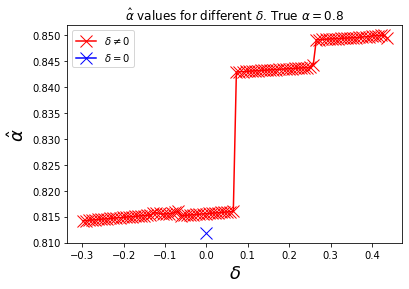

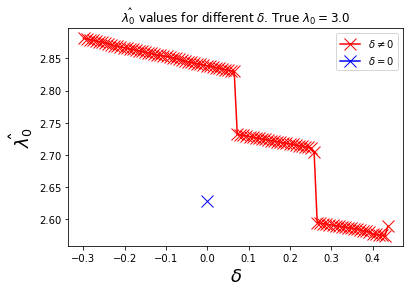

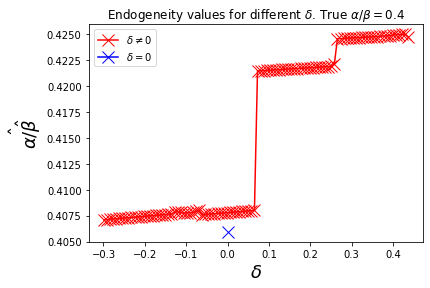

In [54]:
parameters_delta_0_varying_timestamps_least_squares, parameters_results_varying_timestamps_least_squares, mean_parameters_0_varying_timestamps_least_squares, mean_parameters_delta_varying_timestamps_least_squares = experiment_varying_timestamps_least_squares(3.0, 100, 0.8, 2.0, 100, 500)
